In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset


In [8]:
# Load cleaned dataset
file_path = "dataset/cleaned_creditcard.csv"
df = pd.read_csv(file_path)

In [9]:
# Separate features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
# Define simple MLP Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Training function
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Evaluate
        model.eval()
        y_pred_test = []
        y_true_test = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch).squeeze()
                y_pred_test.extend(y_pred.numpy())
                y_true_test.extend(y_batch.numpy())

        auc = roc_auc_score(y_true_test, y_pred_test)
        print(f"Epoch {epoch+1}/{epochs} - AUC: {auc:.4f}")


# Function to plot AUC-ROC curve
def plot_roc_curve(y_true, y_pred_prob, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"AUC-ROC Curve - {model_name}")
    plt.legend()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Function to plot Precision-Recall Curve
def plot_precision_recall(y_true, y_pred_prob, model_name="Model"):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"{model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.legend()
    plt.show()

# Evaluate and visualize model performance
def evaluate_and_visualize(model, test_loader, model_name="MLP"):
    y_pred_test = []
    y_pred_test_prob = []
    y_true_test = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred_prob = model(X_batch).squeeze()
            y_pred = (y_pred_prob > 0.5).float()  # Convert probabilities to binary predictions
            y_pred_test_prob.extend(y_pred_prob.numpy())
            y_pred_test.extend(y_pred.numpy())
            y_true_test.extend(y_batch.numpy())

    # Compute AUC
    auc = roc_auc_score(y_true_test, y_pred_test_prob)
    print(f"{model_name} Model AUC: {auc:.4f}")

    # Plot visualization
    plot_roc_curve(y_true_test, y_pred_test_prob, model_name)
    plot_confusion_matrix(y_true_test, y_pred_test, model_name)
    plot_precision_recall(y_true_test, y_pred_test_prob, model_name)


Epoch 1/10 - AUC: 0.9631
Epoch 2/10 - AUC: 0.9600
Epoch 3/10 - AUC: 0.9653
Epoch 4/10 - AUC: 0.9586
Epoch 5/10 - AUC: 0.9621
Epoch 6/10 - AUC: 0.9684
Epoch 7/10 - AUC: 0.9628
Epoch 8/10 - AUC: 0.9594
Epoch 9/10 - AUC: 0.9554
Epoch 10/10 - AUC: 0.9510
Model saved to models/mlp_fraud_detection_model.pth
MLP Neural Network Model AUC: 0.9510


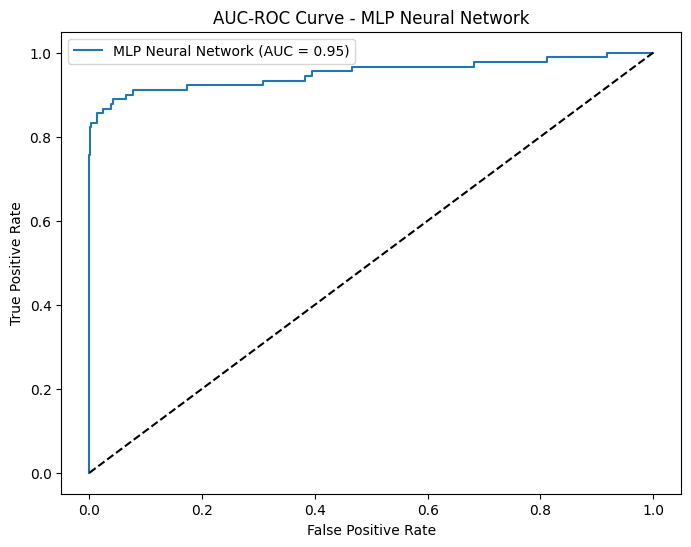

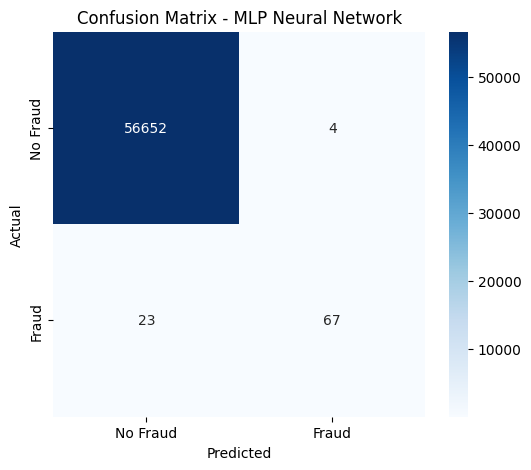

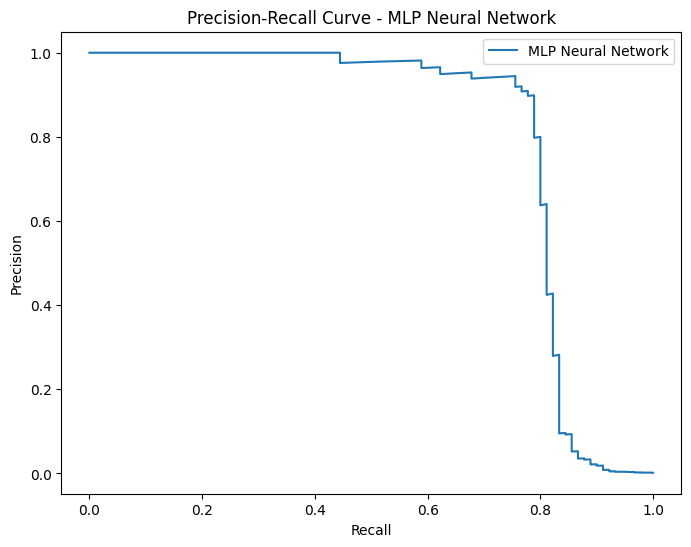

In [11]:
# Train MLP Model
mlp_model = MLP(input_size=X.shape[1])
train_model(mlp_model, train_loader, test_loader, epochs=10)

# Save the trained model
model_path = "models/mlp_fraud_detection_model.pth"
torch.save(mlp_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Run evaluation and visualization for MLP
evaluate_and_visualize(mlp_model, test_loader, "MLP Neural Network")
